# Model comparison to GLODAP : GLOBAL
This notebook shows a means of comparing MOM6 ocean model data to GLODAP data for the entire globe. Model data are interpolated onto the cruise station locations using `xesmf`. See [here](https://www.glodap.info/) for information on GLODAP.

In [110]:
import pandas as pd
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import gfdl_utils as gu
import glob
import re
from scipy.interpolate import griddata
import geopy as geopy
import cmocean

## Read GLODAP data

In [111]:
rootdir = '/work/gam/glodap/'
filename = 'GLODAPv2.2022_Merged_Master_File.csv'
df = pd.read_csv(rootdir+filename,na_values=-9999)

/vftmp/Graeme.Macgilchrist/pid15469/ipykernel_8857/364509296.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(rootdir+filename,na_values=-9999)


## Plot options
Specify a WOCE/GO-SHIP section line to look at, and a year range for the model.

In [112]:
time = '2010-2014'

In [234]:
# GLODAP:model variable naming conventions
model2glodap_names = {'cfc12':'cfc12','cfc11':'cfc11','sf6':'sf6','thetao':'theta','so':'salinity'}
variable_kwargs = {
    'cfc12':{'conversion':1e12/1035,'cmap':'Greens','units':'pmolkg-1','anombins':np.arange(-1,1.05,0.05)},
    'cfc11':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1'},
    'sf6':{'conversion':1e12/1035,'cmap':'PuRd','units':'pmolkg-1','anombins':np.arange(-1,1.05,0.05)},
    'theta':{'conversion':1,'cmap':cmocean.cm.thermal,'units':'degK','bins':np.arange(-2,34,0.2),'anombins':np.arange(-4,4.05,0.05)},
    'salinity':{'conversion':1,'cmap':cmocean.cm.haline,'units':'psu','bins':np.arange(30,38,0.05),'anombins':np.arange(-1,1.02,0.02)}
}

## Read model data

In [114]:
# odiv-233 : /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p125/gfdl.ncrc4-intel18-prod-openmp/pp
# odiv-231 : /archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp

pathDict = {'pp':'/archive/Raphael.Dussin/FMS2019.01.03_devgfdl_20221223/CM4_historical_c192_OM4p25/gfdl.ncrc4-intel18-prod-openmp/pp',
            'out':'av'}
pathDict['ppname']='ocean_inert_z_1x1deg'
pathDict['time']=time
pathDict['local']='annual_5yr'
pathDict['add']='ann'

In [115]:
dsm = gu.core.open_frompp(**pathDict)

In [116]:
# Add T and S
pathDict['ppname'] = 'ocean_annual_z_1x1deg'
dsm = xr.merge([dsm,gu.core.open_frompp(**pathDict)[['so','thetao']]])

In [117]:
dsm = dsm.rename(model2glodap_names)

In [118]:
rolllon = dsm['lon'].roll(lon=180)
newlon = rolllon.where(rolllon<180,-1*(360-rolllon))
dsm = dsm.roll(lon=180).assign_coords({'lon':newlon})

In [119]:
gridpath = gu.core.get_pathstatic(pathDict['pp'],pathDict['ppname'])
grid = xr.open_dataset(gridpath)

rolllon = grid['lon'].roll(lon=180)
newlon = rolllon.where(rolllon<180,-1*(360-rolllon))
grid = grid.roll(lon=180).assign_coords({'lon':newlon})

## Select GLODAP data for model year

In [120]:
# Find cruises that fall within model averaging period
year_bnds = dsm['time_bnds'].squeeze().dt.year.values
leeway = 1
cond = df['G2year']==''
for year in df['G2year'].unique():
    if year_bnds[0]-leeway <= year <= year_bnds[1]+leeway:
        cond += (df['G2year']==year)
dfo = df[cond]
if len(dfo)==0:
    yearstr = [str(e) for e in df['G2year'].unique()]
    raise Exception('No suitable GLODAP data for selected years')

## Derive locations of each GLODAP station, and get corresponding model data

In [121]:
import xesmf as xe
import sectionate

In [235]:
glodap_variables = ['theta','salinity','cfc12']
# Subselect data where this variable is measured
dfo = dfo[np.isfinite(dfo['G2'+glodap_variables[-1]])]

# Use expocode to identify unique cruises
cruises = dfo['G2expocode'].unique()

# For each cruise and each station...
# Get max number of bottles
# and number of stations
maxn = 0
ns = 0
for cruise in cruises:
    dfonow = dfo[dfo['G2expocode']==cruise]
    stations = dfonow['G2station'].unique()
    
    ns += len(stations)
    # Find max no. measurements at each station
    for i,station in enumerate(stations):
        dfostation = dfonow[dfonow['G2station']==station]
        if len(dfostation)>maxn:
            maxn = len(dfostation)
nb = maxn

# For each cruise and each station...
# Get the data
lons = np.full(shape=(ns,),fill_value=np.nan)
lats = np.full(shape=(ns,),fill_value=np.nan)
depths = np.full(shape=(ns,nb),fill_value=np.nan)
variables = {}
for gv in glodap_variables:
    variables[gv]=np.full(shape=(ns,nb),fill_value=np.nan)
    
ist = 0
for cruise in cruises:
    dfonow = dfo[dfo['G2expocode']==cruise]
    stations = dfonow['G2station'].unique()
    
    # Populate numpy arrays at each station
    for station in stations:
        dfostation = dfonow[dfonow['G2station']==station]
        lon = dfostation['G2longitude'].mean()
        lat = dfostation['G2latitude'].mean()
        depth = dfostation['G2depth']
        n = len(dfostation)
        
        lons[ist,]=lon
        lats[ist,]=lat
        depths[ist,:n]=depth
        
        for variable in variables.keys():
            tmp = dfostation['G2'+variable]
            variables[variable][ist,:n] = tmp
        ist+=1
        
# Assign to dataset
dso = xr.Dataset({
                    'lon':xr.DataArray(lons,dims=('location')),
                    'lat':xr.DataArray(lats,dims=('location')),
                    'depth':xr.DataArray(depths,dims=('location','n'))}
)


for variable,array in variables.items():
    dso[variable] = xr.DataArray(array,dims=('location','n'))

In [236]:
# Subselect model
regridder = xe.Regridder(grid, dso, "bilinear", locstream_out=True)
tmp = regridder(dsm.squeeze()).drop_dims(['bnds','z_i'])
dsmo = tmp.sel({'z_l':dso['depth']},method='nearest').drop(['z_l','time'])
# Apply conversion
for key,value in dsmo.items():
    if key=='volcello':
        continue
    dsmo[key] = value*variable_kwargs[key]['conversion']

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


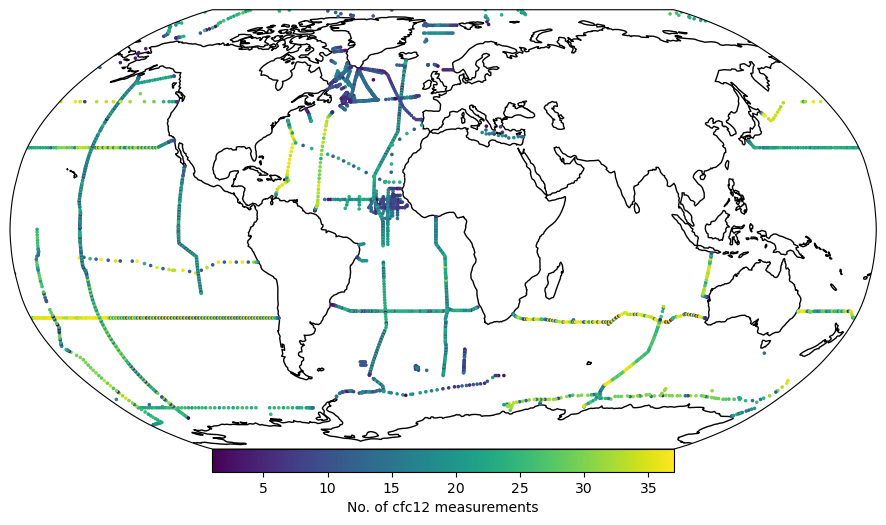

In [237]:
fig,ax=plt.subplots(figsize=(12,6),subplot_kw={'projection':ccrs.Robinson()})
ax.set_global()
ax.coastlines()
x = dso['lon']
y = dso['lat']
c = np.isfinite(dso['depth']).sum('n')
l = ax.scatter(x,y,s=10,c=c,transform=ccrs.PlateCarree(),marker='.')
cb = plt.colorbar(l,ax=ax,orientation='horizontal',fraction=0.05,pad=-0.001)
cb.set_label("No. of "+glodap_variables[-1]+" measurements")

### T-S, groups and histograms

In [241]:
bias = dsmo - dso

groupvar = 'theta'
anomaly = False

if anomaly:
    bins = variable_kwargs[groupvar]['anombins']
    dagroup = bias[groupvar]
else:
    bins = variable_kwargs[groupvar]['bins']
    dagroup = dsmo[groupvar]

gs = {}
g = bias.groupby_bins(dagroup,bins,squeeze=False)
gs['mean'] = g.mean()
gs['std'] = g.std()
bin_centers = [i.mid for i in gs['mean'][groupvar+'_bins'].values]

hs = xr.Dataset()
hs['count'] = histogram(dagroup,bins=[bins],dim=['location','n'],bin_dim_suffix='_bins')

In [242]:
variable = glodap_variables[-1]

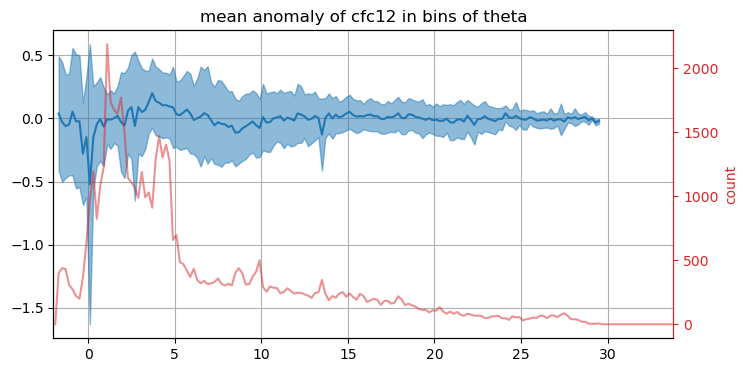

In [243]:
fig,ax = plt.subplots(figsize=(8,4))
ax.plot(bin_centers,gs['mean'][variable],zorder=10)
ax.fill_between(bin_centers,gs['mean'][variable]-gs['std'][variable],gs['mean'][variable]+gs['std'][variable],color='tab:blue',alpha=0.5,zorder=9)
ax.set_xlim([np.min(bins),np.max(bins)])
ax.set_label(variable_kwargs[groupvar]['units'])
ax.grid()
ax.set_title('mean anomaly of '+variable+' in bins of '+groupvar)
axc = ax.twinx()
im = axc.plot(bin_centers,hs['count'],color='tab:red',alpha=0.5)
axc.set_ylabel('count')
axc.spines['right'].set_color('tab:red')
axc.yaxis.label.set_color('tab:red')
axc.tick_params(axis='y', colors='tab:red')

In [244]:
groupvar1 = 'salinity'
groupvar2 = 'theta'
variable = glodap_variables[-1]
# variable = 'theta'

bins = [variable_kwargs[groupvar1]['bins'],variable_kwargs[groupvar2]['bins']]
dagroup1 = dsmo[groupvar1]
dagroup2 = dsmo[groupvar2]

# Histogram biases
hs = xr.Dataset()
hs['count']=histogram(dagroup1,dagroup2,bins=bins,dim=['location','n'])
for key,value in bias.items():
    if key=='depth':
        continue
    hs[key+'_sum']=histogram(dagroup1,dagroup2,bins=bins,dim=['location','n'],weights=value)
    hs[key+'_mean']=hs[key+'_sum']/hs['count']

# Histogram model
hsm = xr.Dataset()
hsm['volume_sum'] = histogram(dsm[groupvar1],dsm[groupvar2],
                              bins=bins,
                              dim=['lon','lat','z_l'],
                              weights=dsm['volcello'])
hsm[variable+'_sum'] = histogram(dsm[groupvar1],dsm[groupvar2],
                                 bins=bins,
                                 dim=['lon','lat','z_l'],
                                 weights=dsm['volcello']*dsm[variable]*variable_kwargs[variable]['conversion'])
hsm[variable+'_mean'] = hsm[variable+'_sum']/hsm['volume_sum']
hsm = hsm.squeeze()

In [246]:
x,y = np.meshgrid(hs[groupvar1+'_bin'],hs[groupvar2+'_bin'])
c = hs[variable+'_mean'].values

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/vftmp/Graeme.Macgilchrist/pid15469/ipykernel_8857/3548974252.py:12: UserWarning: The following kwargs were not used by contour: 'shading'
  ax.contour(hsm[groupvar1+'_bin'],hsm[groupvar2+'_bin'],V.T,levels=[12,13,14,15,16],shading='auto',cmap='inferno',alpha=0.3)
/vftmp/Graeme.Macgilchrist/pid15469/ipykernel_8857/3548974252.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


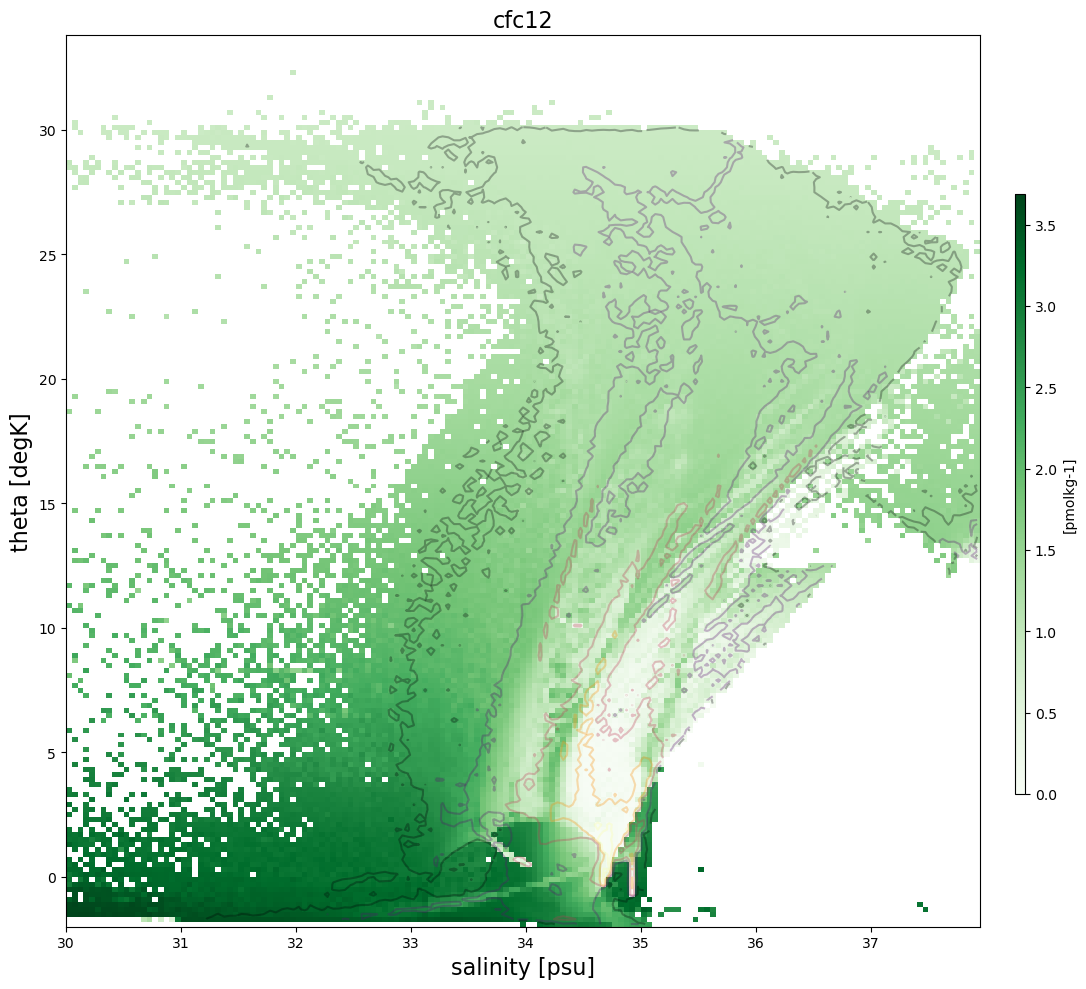

In [265]:
addanomaly = False
addvolume = True

units = variable_kwargs[variable]['units']
cmap = variable_kwargs[variable]['cmap']
clims = [variable_kwargs[variable]['anombins'][0],variable_kwargs[variable]['anombins'][-1]]
fig,ax = plt.subplots(ncols=1,figsize=(10,10))
im1 = ax.pcolormesh(hsm[groupvar1+'_bin'],hsm[groupvar2+'_bin'],hsm[variable+'_mean'].T,
                      shading='auto',cmap=cmap,vmin=0)
if addvolume:
    V = np.log10(hsm['volume_sum'])#.rolling(dim={groupvar1+'_bin':3,groupvar2+'_bin':3},center=True).mean([groupvar1+'_bin',groupvar2+'_bin'])
    ax.contour(hsm[groupvar1+'_bin'],hsm[groupvar2+'_bin'],V.T,levels=[12,13,14,15,16],shading='auto',cmap='inferno',alpha=0.3)
    
if addanomaly:
    im2 = ax.scatter(x,y,s=3,c=c.T,cmap='RdBu_r',zorder=100)
    im2.set_clim(clims)

# Labels
ax.set_xlabel(groupvar1+' ['+variable_kwargs[groupvar1]['units']+']',fontsize=16)
ax.set_ylabel(groupvar2+' ['+variable_kwargs[groupvar2]['units']+']',fontsize=16)
ax.set_title(variable,fontsize=16)

# Add colorbars
axc1 = fig.add_axes([1.02,0.2,0.01,0.6])
cb = fig.colorbar(im1,axc1,orientation='vertical')
if addanomaly:
    axc2 = fig.add_axes([1.02+0.06,0.2,0.01,0.6])
    cb = fig.colorbar(im2,axc2,orientation='vertical')
cb.set_label('['+units+']')

# 
fig.tight_layout()
# fig.add_axes([
# im = ax[1].pcolormesh(hsm[groupvar1+'_bin'],hsm[groupvar2+'_bin'],np.log10(hsm['volume_sum']).T,
#                       shading='auto',cmap='inferno',vmin=0)
# plt.colorbar(im,ax=ax[1],orientation='horizontal')

/nbhome/gam/miniconda3/envs/om4labs/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in log10
  return func(*(_execute_task(a, cache) for a in args))
/vftmp/Graeme.Macgilchrist/pid15469/ipykernel_8857/1429710933.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


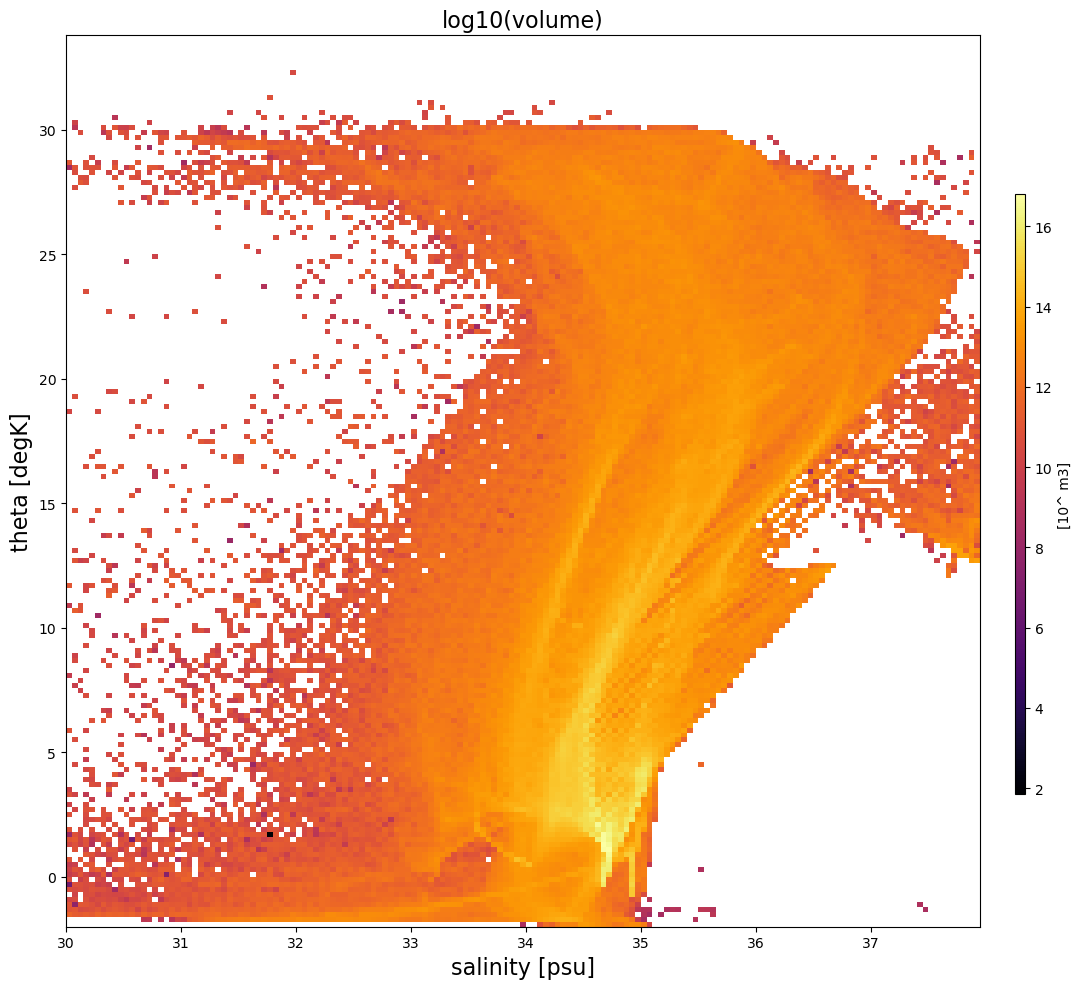

In [250]:
units = variable_kwargs[variable]['units']
fig,ax = plt.subplots(ncols=1,figsize=(10,10))
im1 = ax.pcolormesh(hsm[groupvar1+'_bin'],hsm[groupvar2+'_bin'],np.log10(hsm['volume_sum']).T,
                      shading='auto',cmap='inferno')

# Labels
ax.set_xlabel(groupvar1+' ['+variable_kwargs[groupvar1]['units']+']',fontsize=16)
ax.set_ylabel(groupvar2+' ['+variable_kwargs[groupvar2]['units']+']',fontsize=16)
ax.set_title('log10(volume)',fontsize=16)

# Add colorbars
axc1 = fig.add_axes([1.02,0.2,0.01,0.6])
cb = fig.colorbar(im1,axc1,orientation='vertical')
cb.set_label('[10^ m3]')

# 
fig.tight_layout()
# fig.add_axes([
# im = ax[1].pcolormesh(hsm[groupvar1+'_bin'],hsm[groupvar2+'_bin'],np.log10(hsm['volume_sum']).T,
#                       shading='auto',cmap='inferno',vmin=0)
# plt.colorbar(im,ax=ax[1],orientation='horizontal')